In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [3]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
eval_mode = model.eval()

In [4]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# eagle_idx = os.listdir(eagle_dir)[1]
# eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


generate baseline 

In [9]:
def make_interpolation(x, M, baseline):
    lst = [] 
    for i in range(M+1):
        alpha = float(i/M)  
        interpolated =x * (alpha) + baseline * (1-alpha)
        lst.append(interpolated.clone())
    return torch.stack(lst)

In [24]:
def integrated_gradient(model, x, y, baseline, interpolation, device='cuda:0', **kwrags):
    x = x.to(device)
    baseline = baseline.to(device)
    model.zero_grad()
    
#     X = make_interpolation(x, M, baseline)
    X = Variable(interpolation, requires_grad=True).to(device)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    gradient = (gradient[:-1] + gradient[1:]) / 2.0
    output = (x - baseline) * gradient.mean(axis=0)
    output = output.mean(dim=0) # RGB mean
    output = output.abs()
    return output


In [25]:
# ferrot_tensor.size()
# baseline = torch.zeros_like(ferrot_tensor)
# baseline.size()

# X = make_interpolation(ferrot_tensor, 25, baseline)
# X.size()

temp = integrated_gradient(eval_mode.to("cuda:0"), ferrot_tensor, 359, baseline, X, device='cuda:0', M=25)


In [53]:
X.device

device(type='cpu')

StopIteration: 

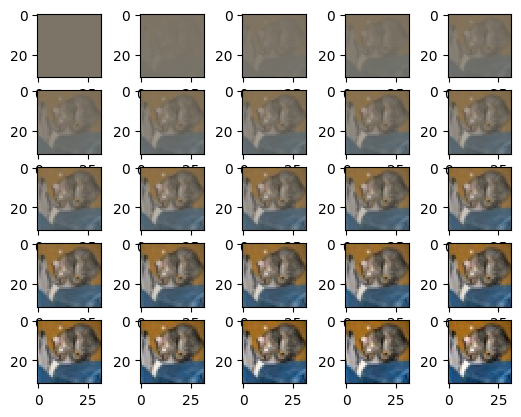

In [51]:
# temp.detach().cpu()
# a = 
result = torch.from_numpy(np.load('/root/results/cifar10/interpolation/image_linear_zero_interpolation.npy'))
t = result[0]
t.shape

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(26):
    ax = next(axes_flat)
#     b = torch.numpy_to_tensor(t[i])
#     b.size()
    ax.imshow(convert_to_img(t[i]))
#     ax.imshow(np.transpose(t[i], (1, 2, 0)))



In [45]:
t[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [30]:
# model = torch.load('/root/data/cifar10/cifar10/results/densenet/script_model.pt', map_location='cpu')
model.weight

AttributeError: 'RecursiveScriptModule' object has no attribute 'weight'

In [33]:
a, b = valid_datasets[0]
b.type()

AttributeError: 'int' object has no attribute 'type'

In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()